In [1]:
import os
import numpy as np
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.transform import resize

# Load image, mask, label

In [2]:
##Load images, labels, masks
NPY_PATH = r"dataset\numpy"

labels = np.load(os.path.join(NPY_PATH,'labels.npy'))
t1w_images = (np.load(os.path.join(NPY_PATH,'T1W_images.npy')) / 255.0).astype(np.float32)
t2f_images = (np.load(os.path.join(NPY_PATH,'T2F_images.npy')) / 255.0).astype(np.float32)
t2w_images = (np.load(os.path.join(NPY_PATH,'T2W_images.npy')) / 255.0).astype(np.float32)
masks = (np.load(os.path.join(NPY_PATH,'Mask_images.npy')) / 255.0).astype(np.float32)

print(labels.shape)
print(t2w_images.shape)
print(t2f_images.shape)
print(t1w_images.shape)
print(masks.shape)

(2356,)
(2356, 260, 320)
(2356, 260, 320)
(2356, 260, 320)
(2356, 260, 320)


# Resize data

원본 데이터 width : 260 , height : 320 
결과 데이터 width : 256 , height : 256



In [3]:
img_size_ori = (260,320)
img_size_target = (256,320)

# 모델의 입력 형태에 맞추기 위해 차원을 확장합니다.
# example. (,260,320) -> (,260,320,1)
t1w_images = np.expand_dims(t1w_images,axis=-1)
t2f_images = np.expand_dims(t2f_images,axis=-1)
t2w_images = np.expand_dims(t2w_images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

# 이미지의 사이즈를 줄입니다.
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target[0], img_size_target[1]), mode='constant', preserve_range=True,)
    
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori[0], img_size_ori[1]), mode='constant', preserve_range=True)


t1w_images = np.array([ downsample(image) for image in t1w_images ])
t2f_images = np.array([ downsample(image) for image in t2f_images ])
t2w_images = np.array([ downsample(image) for image in t2w_images ])
masks = (np.array([ downsample(mask) for mask in masks ])>0)*1.0

[1562  794]


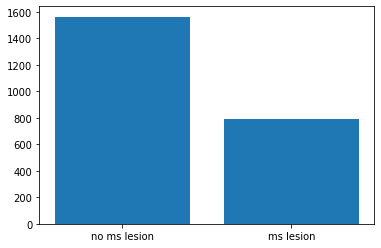

In [4]:
integer_to_class = {'0': 'no ms lesion', '1': 'ms lesion'}

classes, counts = np.unique(labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(integer_to_class.values()))
print(counts)

In [5]:
from sklearn.model_selection import train_test_split
import gc

image_datasets = np.concatenate((t1w_images,t2f_images,t2w_images),axis=0)
mask_datasets = np.concatenate((masks,masks,masks),axis =0)
labels_datasets = np.concatenate((labels,labels,labels),axis =0)

print(image_datasets.shape)
print(mask_datasets.shape)
print(labels_datasets.shape)

(7068, 256, 320, 1)
(7068, 256, 320, 1)
(7068,)


### Train Image and its mask which is to be predicted

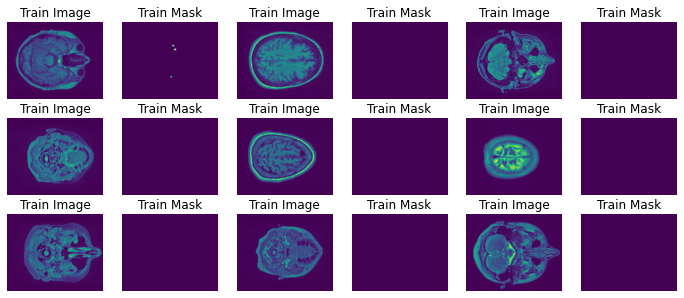

In [6]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint( image_datasets.shape[0], size=9):
  plt.subplot(3,6,i);i+=1
  plt.imshow(image_datasets[idx])
  plt.title("Train Image")
  plt.axis('off')
  plt.subplot(3,6,i);i+=1
  plt.imshow(mask_datasets[idx]) 
  plt.title("Train Mask")
  plt.axis('off')

In [7]:
from sklearn.model_selection import train_test_split
import gc
X,X_v,Y,Y_v = train_test_split( image_datasets,mask_datasets,test_size=0.2,stratify=labels_datasets)

del image_datasets
del mask_datasets
del labels_datasets

gc.collect()

X.shape,X_v.shape

((5654, 256, 320, 1), (1414, 256, 320, 1))

### Augmentation

In [8]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    brightness_range=(0.9,1.1),
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    zoom_range=[.9,1.1],
                                    fill_mode='nearest'
                                   )
val_datagen = ImageDataGenerator()

### Defining Dice Loss
Dice = 2|A∩B|/|A|+|B|

In [9]:
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

### bce_dice_loss = binary_crossentropy_loss + dice_loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [13]:
from model import baseModel, unet_v1, unet_v2, unet_v3

unet = unet_v3(input_shape=(256,320,1))
unet.summary()

Model: "unet_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 320, 1) 0                                            
__________________________________________________________________________________________________
contraction_1_1 (Conv2D)        (None, 256, 320, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
contraction_1_2 (Conv2D)        (None, 256, 320, 16) 2320        contraction_1_1[0][0]            
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 128, 160, 16) 0           contraction_1_2[0][0]            
____________________________________________________________________________________________

### Defining IOU metric and compile Model

In [14]:
def get_iou_vector(A, B):
    t = A > 0
    p = B
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)

    return iou

def iou_metric(label, pred):
    return tf.py_function(get_iou_vector, [label, pred > 0.5], tf.float64)

from keras import optimizers

unet.compile(optimizer=optimizers.Adam(lr=1e-3), 
             loss=bce_dice_loss, metrics=['accuracy',tf.keras.metrics.MeanIoU(num_classes=2,name="mean_iou"])


In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

checkpoint_name = 'model_v2_best_checkpoint.h5'

model_checkpoint  = ModelCheckpoint(checkpoint_name, save_best_only=True, 
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min' , baseline=None)
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

hist = unet.fit(
                    X,
                    Y,
                    batch_size=16,
                    epochs=100,
                    validation_data=(X_v,Y_v),
                    verbose=1,
                    callbacks= callback_list
        )
        



Epoch 1/100
354/354 [==============================] - 59s 155ms/step - loss: 1.0065 - accuracy: 0.9980 - iou_metric: 0.0154 - val_loss: 0.9782 - val_accuracy: 0.9991 - val_iou_metric: 0.0232

Epoch 00001: val_loss improved from inf to 0.97823, saving model to model_v2_best_checkpoint.h5
Epoch 2/100
354/354 [==============================] - 53s 151ms/step - loss: 0.8878 - accuracy: 0.9986 - iou_metric: 0.0749 - val_loss: 0.9006 - val_accuracy: 0.9979 - val_iou_metric: 0.0722

Epoch 00002: val_loss improved from 0.97823 to 0.90060, saving model to model_v2_best_checkpoint.h5
Epoch 3/100
354/354 [==============================] - 54s 151ms/step - loss: 0.8819 - accuracy: 0.9987 - iou_metric: 0.0817 - val_loss: 0.7754 - val_accuracy: 0.9988 - val_iou_metric: 0.1442

Epoch 00003: val_loss improved from 0.90060 to 0.77536, saving model to model_v2_best_checkpoint.h5
Epoch 4/100
354/354 [==============================] - 54s 151ms/step - loss: 0.8121 - accuracy: 0.9987 - iou_metric: 0.1174 

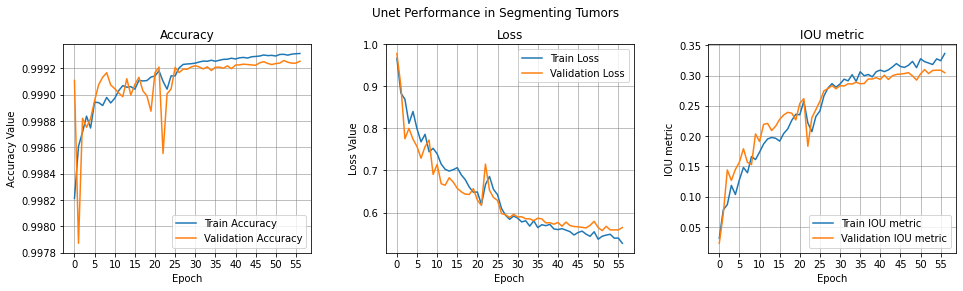

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Unet Performance in Segmenting Tumors', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['mean_iou'], label='Train IOU metric')
ax3.plot(epoch_list, hist.history['val_mean_iou'], label='Validation IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('IOU metric');ax3.set_xlabel('Epoch');ax3.set_title('IOU metric')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

# Load Model

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

unet = load_model(checkpoint_name, custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':tf.keras.metrics.MeanIoU(num_classes=2,name="mean_iou"}) #or compile = False

# unet = load_model(checkpoint_name, custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':tf.keras.metrics.MeanIoU(num_classes=2,name="mean_iou")}) #or compile = False

In [19]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def get_iou_vector(A, B):
    t = A > 0
    p = B
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou
  
def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(0, 1, 100)
  ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best

Text(0.5, 1.0, 'Threshold vs IoU \n (0.30303030303030304, 0.38345848992379505)')

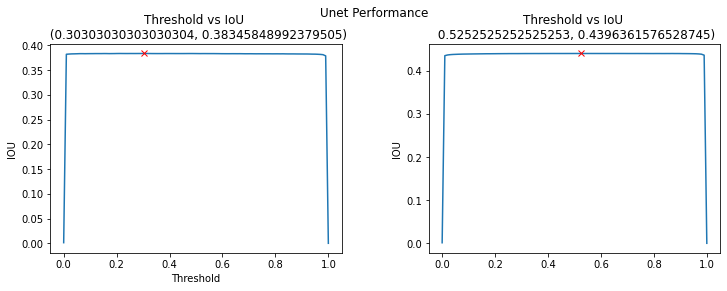

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(Y,unet.predict(X))
ax2.plot(th, ious, label="For Training")
ax2.plot(th_best, iou_best, "xr", label="Best threshold")
ax2.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax2.set_title("Threshold vs IoU \n {}, {})".format(th_best, iou_best))

th, ious, iou_best, th_best = getIOUCurve(Y_v,unet.predict(X_v))
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU \n ({}, {})".format(th_best, iou_best))

In [18]:
print(iou_best,th_best)

0.38345848992379505 0.30303030303030304


In [19]:
THRESHOLD = 0.2
predicted_mask = (unet.predict(X_v)>(th_best))*1

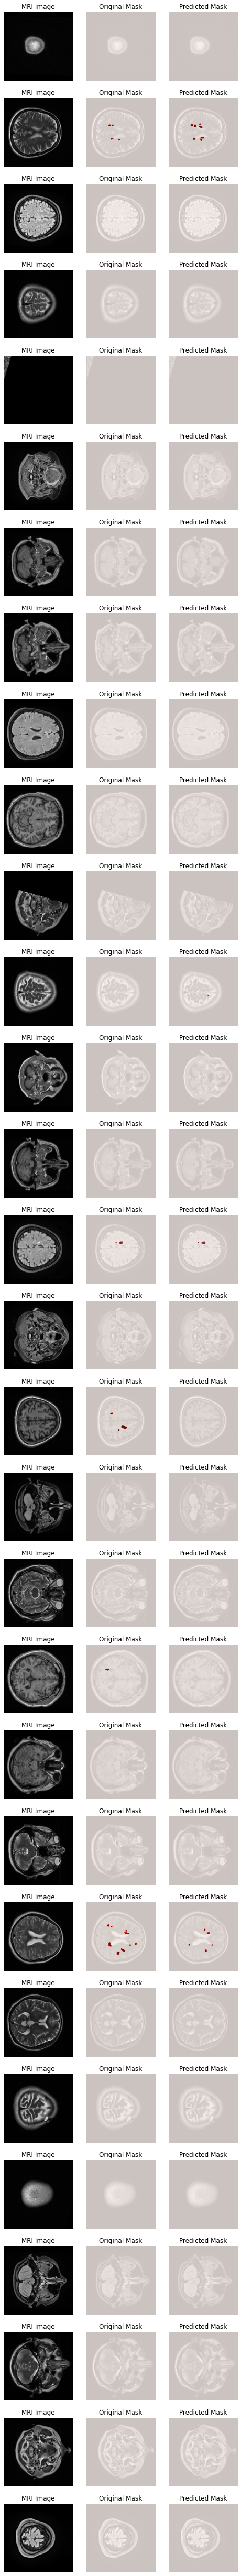

In [22]:
i=1;total=30
temp = np.ones_like( Y_v[0] )

plt.figure(figsize=(8,90))
for idx in np.random.randint(0,high=X_v.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow(X_v[idx], cmap='gray' )
    plt.title("MRI Image");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( X_v[idx], cmap='gray' )
    plt.imshow( Y_v[idx], alpha=0.8, cmap='Reds' )
    plt.title("Original Mask");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( X_v[idx], cmap='gray' )
    plt.imshow( predicted_mask[idx],  alpha=0.8, cmap='Reds' )
    plt.title("Predicted Mask");plt.axis('off')